In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)



from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve

In [2]:
razor = pd.read_pickle('uniprot_new_seqs_threshold_0_57.pkl.gz')
def cleavage(x):
    try:
        return int(x.split('..')[1].split(';')[0])
    except Exception:
        if str(x) != 'nan':
            print(x)
        return np.nan
    
razor['Cleav'] = razor['Signal peptide'].apply(cleavage)

In [3]:
razor.Label.value_counts()

0    52055
1      287
Name: Label, dtype: int64

In [4]:
sp4 = pd.read_csv('../results/new_uniprot.fa.signalp4', skiprows=1, sep='\s+')
sp4 = sp4.rename(columns={'#name':'Entry'})

tmp1 = pd.merge(sp4, razor, on='Entry')
tmp1['SP4_Preds'] = tmp1['?'].apply(lambda x: 1 if x == 'Y' else 0)
tmp1['Razor_Preds'] = tmp1['Median_Y'].apply(lambda x: 1 if x >= 0.56 else 0)


In [5]:
sp5 = pd.read_csv('../results/new_uniprot.fa.signalp5', sep='\t', skiprows=1)
sp5 = sp5.rename(columns={'#ID':'Entry'})
# sp5.head()

tmp2 = pd.merge(tmp1, sp5, on='Entry')
tmp2['SP5_Preds'] = tmp2['Prediction'].apply(lambda x: 1 if x == 'SP(Sec/SPI)' else 0)
tmp2['Prediction'].value_counts()

OTHER          51639
SP(Sec/SPI)      703
Name: Prediction, dtype: int64

In [6]:
def sp5_cleavage(val):
    try:
        cs = int(val.split('CS pos: ')[1].split('-')[0])
    except Exception:
        cs = np.nan
    return cs
tmp2['Cleav_SP5'] = tmp2['CS Position'].apply(sp5_cleavage)

In [7]:
tmp2.head(2)

,Entry,Cmax,pos,Ymax,pos.1,Smax,pos.2,Smean,D,?,...,Toxin_Preds,Toxin_prob,SP4_Preds,Razor_Preds,Prediction,SP(Sec/SPI),OTHER,CS Position,SP5_Preds,Cleav_SP5
0,P0DQE1,0.279,24,0.482,24,0.945,15,0.837,0.674,Y,...,"[True, False, True, True, True]","[0.73, 0.18, 0.68, 0.69, 0.7]",1,1,SP(Sec/SPI),0.950889,0.049111,CS pos: 23-24. SEG-SI. Pr: 0.5976,1,23.0
1,P0DPZ2,0.564,24,0.698,24,0.940,13,0.866,0.789,Y,...,"[True, True, True, True, True]","[0.77, 0.77, 0.77, 0.75, 0.35]",1,1,SP(Sec/SPI),0.879873,0.120127,CS pos: 23-24. KEA-LK. Pr: 0.4170,1,23.0


In [8]:
ds = pd.read_csv('../results/new_uniprot.deepsig', sep='\t', header=None)
ds = ds.drop_duplicates(0)
ds.columns = ['Entry', 'Tool', 'Result', 3, 'Cleav_DeepSig', 'Prob_DeepSig', 6, 7, 8]
ds['Prob_DeepSig'] = ds['Prob_DeepSig'].astype(float, errors='ignore').apply(lambda x: 0 if x == '.' else x)
ds['DeepSig_Preds'] = ds['Result'].apply(lambda x: 1 if x =='Signal peptide' else 0)
ds['Prob_DeepSig'] = ds['Prob_DeepSig'].astype(float)
ds

,Entry,Tool,Result,3,Cleav_DeepSig,Prob_DeepSig,6,7,8,DeepSig_Preds
0,P0DQE1,DeepSig,Signal peptide,1,23,0.91,.,.,evidence=ECO:0000256,1
2,P0DPZ2,DeepSig,Signal peptide,1,23,0.93,.,.,evidence=ECO:0000256,1
4,P0DPV6,DeepSig,Signal peptide,1,23,0.98,.,.,evidence=ECO:0000256,1
6,P0DPU6,DeepSig,Chain,1,197,0.00,.,.,evidence=ECO:0000256,0
7,P19438,DeepSig,Signal peptide,1,24,0.98,.,.,evidence=ECO:0000256,1
...,...,...,...,...,...,...,...,...,...,...
52978,Q8IVQ6,DeepSig,Chain,1,265,0.00,.,.,evidence=ECO:0000256,0
52979,O48626,DeepSig,Chain,1,742,0.00,.,.,evidence=ECO:0000256,0
52980,P45972,DeepSig,Chain,1,705,0.00,.,.,evidence=ECO:0000256,0
52981,Q62394,DeepSig,Chain,1,352,0.00,.,.,evidence=ECO:0000256,0


In [110]:
tmp3_ = pd.merge(tmp2, ds, on='Entry')

In [114]:
tmp3 = tmp3_.copy()

In [111]:
# secreted = pd.read_csv('../data/uniprot_new/uniprot-reviewed yes+keyword Secreted+[KW-0964].tab.gz', sep='\t')
# secreted = secreted[secreted['Signal peptide'].isna()]
# tmp3 = tmp3_[tmp3_.Entry.apply(lambda x: x not in secreted.Entry.values)].copy()

In [115]:
tmp3.Label.value_counts()

0    52055
1      287
Name: Label, dtype: int64

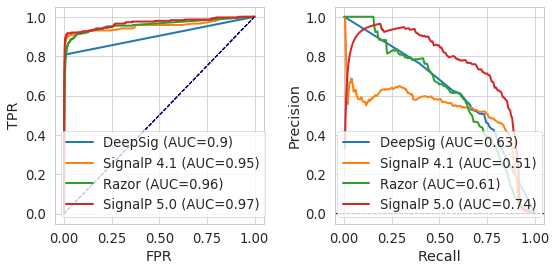

In [116]:
cols = ['Prob_DeepSig', 'D', 'Median_Y', 'SP(Sec/SPI)', ]
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0', ]


new = tmp3.copy()
# new['Final_Predicted_Class'] = new['?'].apply(lambda x: 1 if x == 'Y' else 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),)

for i, v in enumerate(cols):

    preds = new[v]
    y = new['Label']

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=ax[0], lw=2)
    #baseline
    ax[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=ax[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    ax[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')



    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')


fig.tight_layout()
# print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);

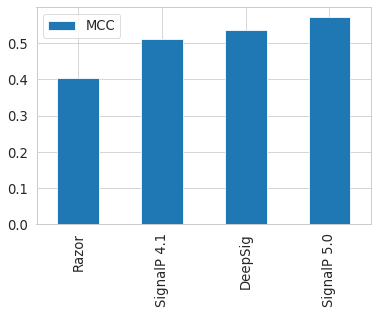

In [117]:
for_mcc = ['Razor_Preds', 'SP4_Preds', 'SP5_Preds', 'DeepSig_Preds']
mcc_df = pd.DataFrame(columns=['Razor', 'SignalP 4.1', 'SignalP 5.0', 'DeepSig'], index=['MCC'])

new = tmp3.copy()

for i, v in enumerate(mcc_df.columns):
    mcc_df.loc['MCC', v] = matthews_corrcoef(new['Label'], new[for_mcc[i]])

mcc_df.transpose().sort_values(by='MCC').plot(kind='bar')

In [118]:
mcc_df

,Razor,SignalP 4.1,SignalP 5.0,DeepSig
MCC,0.40457,0.511022,0.571207,0.537475


In [119]:

new = tmp3.copy()

cleavage_precision = []
cleavage_recall = []


# Razor
new['Diff'] = np.abs(new['Cleav'] - new['Median_Cleavage'].apply(lambda x: x[0]))
false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Razor_Preds'] == 1].copy()
true_n = false[false['Razor_Preds'] == 0].copy()

false_n = true[true['Razor_Preds'] == 0].copy()
true_p = true[true['Razor_Preds'] == 1].copy()



csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Razor_Preds'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)



csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)

cleavage_precision.append(csp)
cleavage_recall.append(css)


# SignalP4
new['Diff'] = np.abs(new['pos'] -1  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['SP4_Preds'] == 1].copy()
true_n = false[false['SP4_Preds'] == 0].copy()

false_n = true[true['SP4_Preds'] == 0].copy()
true_p = true[true['SP4_Preds'] == 1].copy()



csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['SP4_Preds'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)



csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)

cleavage_precision.append(csp)
cleavage_recall.append(css)



# SignalP5
new['Diff'] = np.abs(new['Cleav_SP5']  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['SP5_Preds'] == 1].copy()
true_n = false[false['SP5_Preds'] == 0].copy()

false_n = true[true['SP5_Preds'] == 0].copy()
true_p = true[true['SP5_Preds'] == 1].copy()



csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['SP5_Preds'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)



csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)

cleavage_precision.append(csp)
cleavage_recall.append(css)



# DeepSig
new['Diff'] = np.abs(new['Cleav_DeepSig'] - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['DeepSig_Preds'] == 1].copy()
true_n = false[false['DeepSig_Preds'] == 0].copy()

false_n = true[true['DeepSig_Preds'] == 0].copy()
true_p = true[true['DeepSig_Preds'] == 1].copy()



csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['DeepSig_Preds'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)



csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)

cleavage_precision.append(csp)
cleavage_recall.append(css)

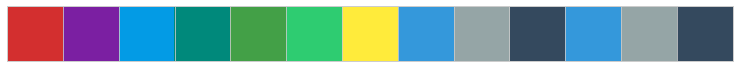

In [25]:
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]
sns.palplot(flatui)

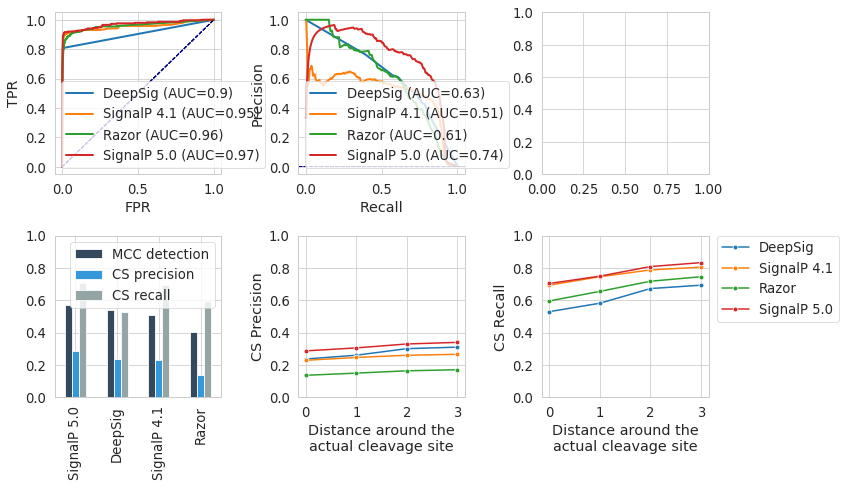

In [120]:



cols = ['Prob_DeepSig', 'D', 'Median_Y', 'SP(Sec/SPI)', ]
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0', ]


new = tmp3.copy()
# new['Final_Predicted_Class'] = new['?'].apply(lambda x: 1 if x == 'Y' else 0)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7),)
axes = ax.flatten()

for i, v in enumerate(cols):

    preds = new[v]
    y = new['Label']

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=axes[0], lw=2)
    #baseline
    axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=axes[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    axes[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')



    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')


# fig.tight_layout()
# # print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);

















barplt = pd.DataFrame(columns=['MCC detection', 'CS precision', 'CS recall'],\
                      index=['Razor', 'SignalP 5.0', 'SignalP 4.1', 'DeepSig'])
# barplt.loc['RAZOR'] = [np.max(mcc), csp['CS Precision'].cumsum().round(3)[0], css['CS Recall'].cumsum().round(3)[0]]
barplt.loc['Razor'] = [mcc_df.loc['MCC', 'Razor'], \
                       cleavage_precision[0]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[0]['CS Recall'].cumsum().round(3)[0]]


barplt.loc['SignalP 4.1'] = [mcc_df.loc['MCC', 'SignalP 4.1'], \
                       cleavage_precision[1]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[1]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['SignalP 5.0'] = [mcc_df.loc['MCC', 'SignalP 5.0'], \
                       cleavage_precision[2]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[2]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['DeepSig'] = [mcc_df.loc['MCC', 'DeepSig'], \
                       cleavage_precision[3]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[3]['CS Recall'].cumsum().round(3)[0]]
# barplt.loc['DeepSig'] = [0.819, 0.604, 0.624]

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),)
sns.set_context("paper", font_scale=1.5)
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]


# sns.set_palette(flatui)
barplt.sort_values(ascending=False, by='MCC detection').plot(kind='bar', \
                                                                ax=axes[3], \
                                                                color=["#34495e", "#3498db", "#95a5a6",],\
                                                            )#.legend(loc='lower left', facecolor='white', framealpha=1);


axes[3].set(ylim=(0.0, 1))

sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[3]['CS Precision'].cumsum()[:4], ax=axes[4], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[1]['CS Precision'].cumsum()[:4], \
              ax=axes[4], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[0]['CS Precision'].cumsum()[:4],\
              ax=axes[4], lw=1.5, marker="o")
# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.671, 0.702, 0.732, 0.732], color=flatui[1], ax=ax[1], lw=1.5, marker="o")

sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[2]['CS Precision'].cumsum()[:4],  ax=axes[4], lw=1.5, marker="o")


# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.604, 0.631, 0.668, 0.700], color=flatui[3], ax=ax[1], lw=1.5, marker="o")
axes[4].set(ylim=(0.0, 1))
# 

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[3]['CS Recall'].cumsum()[:4],\
             label='DeepSig', ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[1]['CS Recall'].cumsum()[:4],\
             label='SignalP 4.1',  ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[0]['CS Recall'].cumsum()[:4], ax=axes[5],\
              lw=1.5, label='Razor', marker="o")
# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.729, 0.762, 0.795, 0.833], label='SignalP 5.0', color=flatui[1], ax=ax[2], lw=1.5, marker="o")

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[2]['CS Recall'].cumsum()[:4],\
             label='SignalP 5.0', ax=axes[5], lw=1.5, marker="o")


# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.624, 0.652, 0.690, 0.724], label='DeepSig', color=flatui[3], ax=ax[2], lw=1.5, marker="o")
axes[5].set(ylim=(0.0, 1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.tight_layout();
# plt.savefig('../figs/new_benchmarking_cleavage_sites_all.pdf',  bbox_inches='tight', pad_inches=0)

In [122]:
barplt

,MCC detection,CS precision,CS recall
Razor,0.40457,0.136,0.596
SignalP 5.0,0.571207,0.287,0.704
SignalP 4.1,0.511022,0.229,0.693
DeepSig,0.537475,0.237,0.53


In [124]:
names = ['Razor', 'SignalP 4.1', 'SignalP 5.0', 'DeepSig']
for i, v in enumerate(cleavage_precision):
    print(names[i])
    print(v['CS Precision'].cumsum()[:4].round(3))

Razor
0    0.136
1    0.150
2    0.164
3    0.171
Name: CS Precision, dtype: float64
SignalP 4.1
0    0.229
1    0.247
2    0.260
3    0.266
Name: CS Precision, dtype: float64
SignalP 5.0
0    0.287
1    0.306
2    0.330
3    0.340
Name: CS Precision, dtype: float64
DeepSig
0    0.237
1    0.261
2    0.301
3    0.310
Name: CS Precision, dtype: float64


In [123]:
names = ['Razor', 'SignalP 4.1', 'SignalP 5.0', 'DeepSig']
for i, v in enumerate(cleavage_recall):
    print(names[i])
    print(v['CS Recall'].cumsum()[:4].round(3))

Razor
0    0.596
1    0.655
2    0.718
3    0.746
Name: CS Recall, dtype: float64
SignalP 4.1
0    0.693
1    0.746
2    0.787
3    0.805
Name: CS Recall, dtype: float64
SignalP 5.0
0    0.704
1    0.749
2    0.808
3    0.833
Name: CS Recall, dtype: float64
DeepSig
0    0.530
1    0.582
2    0.672
3    0.693
Name: CS Recall, dtype: float64


In [39]:
tmp3.Label.value_counts()

0    45675
1      287
Name: Label, dtype: int64

In [126]:
tmp3[['Entry', 'Label']].reset_index(drop=True).to_csv('../results/benchmark_sp_new.csv.gz',\
                                                                                      index=None)

In [41]:
cleavage_precision[0]['CS Precision'].cumsum().round(3)[0], \
cleavage_recall[0]['CS Recall'].cumsum().round(3)[0]

(0.141, 0.596)

In [22]:
for i, v in enumerate(['SP5_Preds', 'SP4_Preds', 'DeepSig_Preds', 'Razor_Preds']):
    print('{} out of {} predicted as SP by {}.'.format(new[new[v] == 1].shape[0], new.Label.value_counts()[1], v))

681 out of 287 predicted as SP by SP5_Preds.
846 out of 287 predicted as SP by SP4_Preds.
568 out of 287 predicted as SP by DeepSig_Preds.
1212 out of 287 predicted as SP by Razor_Preds.


In [23]:
for i, v in enumerate(['SP5_Preds', 'SP4_Preds', 'DeepSig_Preds', 'Razor_Preds']):
    print('{} out of {} predictions by {} are correct.'.format(true[true[v] == 1].shape[0], \
                                      new[new[v] == 1].shape[0], v))

258 out of 681 predictions by SP5_Preds are correct.
257 out of 846 predictions by SP4_Preds are correct.
232 out of 568 predictions by DeepSig_Preds are correct.
246 out of 1212 predictions by Razor_Preds are correct.
